USA Grid

In [2]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install gmaps

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
import numpy as np
import pickle
import gmaps

In [9]:
states = gpd.read_file('/nnproject/geoguessr/data/cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp')

In [10]:
states

,AFFGEOID,GEOID,NAME,geometry
0,0100000US,US,United States,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."


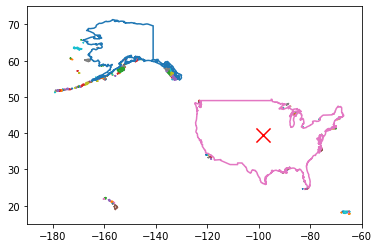

In [12]:
%%capture --no-display
mainland_center = Point(-98.35,39.50)
for i,j in enumerate(states['geometry'][0]):
    x,y = j.exterior.xy
    plt.plot(x,y)
    if mainland_center.within(j):
        mainland = np.array([(yj,xj) for xj,yj in zip(x,y)])
plt.scatter([-98.35], [39.50], c='r', marker='x', s=200)
plt.xlim([-190,-60])
plt.ylim([15,75])
plt.show()

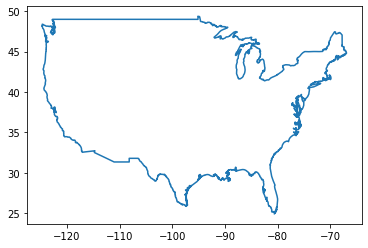

In [13]:
plt.plot(mainland[:,1],mainland[:,0])
plt.show()

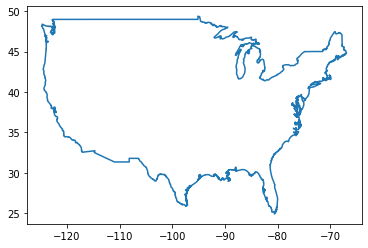

In [17]:
pickle.dump(mainland,open("/nnproject/geoguessr/data/pickled_data/mainland.pickle","wb"))
mainland = pickle.load(open("/nnproject/geoguessr/data/pickled_data/mainland.pickle", "rb"))
mainland = Polygon(np.flip(mainland))
x,y = mainland.exterior.xy
plt.plot(x,y)

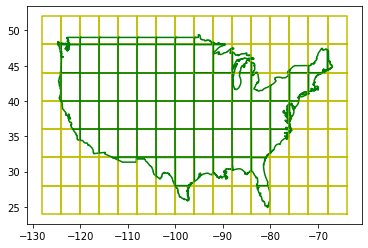

In [18]:
value = mainland.bounds
base = 4

min_x = int(value[0]//base)
min_y = int(value[1]//base)
max_x = int(value[2]//base)
max_y = int(value[3]//base)

for i in range(min_x, max_x + 1):
    for j in range(min_y, max_y + 1):
        y = shapely.geometry.box(i*base, j*base, (i+1)*base, (j+1)*base)
        r = mainland.intersection(y)
        x,y = y.exterior.xy
        plt.plot(x,y,c='y')
        if r.is_empty:
            continue
        elif type(r) == shapely.geometry.multipolygon.MultiPolygon:
            for gems in r.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='g')
        else:
            x,y = r.exterior.xy
            plt.plot(x,y,c='g')
plt.show()

In [19]:
def partition(mainland, base, mergeFactor):
    '''
    polygon: Unsplit polygon of mainland US
    dim: The dimensions of each grid to split the map into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    value = mainland.bounds
    min_x = int(value[0]//base)
    min_y = int(value[1]//base)
    max_x = int(value[2]//base)
    max_y = int(value[3]//base)
    grid = 0
    res = []
    for i in range(min_x, max_x+1):
        for j in range(min_y, max_y+1):
            y = shapely.geometry.box(i*base, j*base, (i+1)*base, (j+1)*base)
            r = mainland.intersection(y)
            if r.is_empty:
                continue
            if type(r)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in r.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(r)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL
    
    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)
        
    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

def plotMap(mainlandGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in mainlandGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0],v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

In [20]:
mainlandGrid = partition(mainland, base, mergeFactor=0.2)
len(mainlandGrid)

65

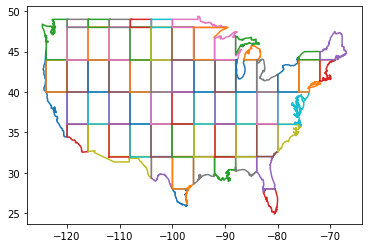

In [21]:
for i in mainlandGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()

In [23]:
pickle.dump(mainlandGrid,open("/home/maf3r/nnproject/geoguessr/data/pickled_data/mainlandGrid.pickle","wb"))

Data Scraper For Training Data

In [24]:
# Insert API key
key = ''
import requests
import json, os
import urllib.request
import random
dataDir = "/nnproject/geoguessr/data/training_data"

In [26]:
# Data is scraped from all grids
# searchGrids = mainlandGrid.keys()

# Data is scraped for first 3 grids
searchGrids = list(range(0,3))
print("Search in Grids: {}".format("All" if searchGrids==mainlandGrid.keys() else searchGrids))

Search in Grids: [0, 1, 2]


In [ ]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=400x200&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGrids==mainlandGrid.keys() else searchGrids))
for grid,coor in mainlandGrid.items():        
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = dataDir
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        imgnum = 0
        
        # Only scraping 8 locations for training data (3 pictues from each location)
        while count<8 and trials<4:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)

                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, key)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(grid,imgnum))
                            imgnum += 1
                        count += 1
                        trials = 0
                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print("No duplicates: {}".format(len(locList)==len(set(locList))))

Data Scraper For Testing Data

In [27]:
# Change to save images to testing data folder
dataDir = "/home/maf3r/nnproject/geoguessr/data/testing_data"

In [ ]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=400x200&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGrids==mainlandGrid.keys() else searchGrids))
for grid,coor in mainlandGrid.items():        
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = dataDir
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        imgnum = 0
        
        # Only scraping 2 locations for testing data (3 pictues from each location)
        while count<2 and trials<4:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)

                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, key)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(grid,imgnum))
                            imgnum += 1
                        count += 1
                        trials = 0
                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print("No duplicates: {}".format(len(locList)==len(set(locList))))

Load images into numpy array

In [46]:
from PIL import Image
import glob

# Load training data images
filelist = glob.glob('/home/maf3r/nnproject/geoguessr/data/training_data/*.jpg')

In [47]:
x_train = np.array([np.array(Image.open(fname)) for fname in filelist])
print(x_train.shape)

(1560, 200, 400, 3)


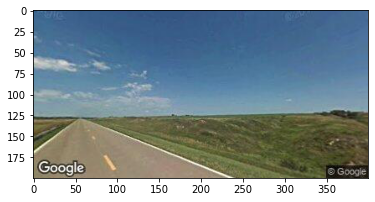

In [48]:
plt.imshow(x_train[6])

In [49]:
# Load testing data images
filelist = glob.glob('/home/maf3r/nnproject/geoguessr/data/testing_data/*.jpg')

In [50]:
x_test = np.array([np.array(Image.open(fname)) for fname in sorted(filelist)])
print(x_test.shape)

(390, 200, 400, 3)


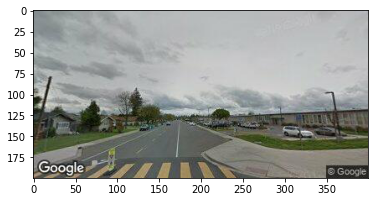

In [51]:
plt.imshow(x_test[0])

Create y_train and y_test numpy arrays

In [53]:
y_train = []
for i in range(1560):
    y_train.append(i // 24)
y_train = np.array(y_train)

In [57]:
print(y_train)

[ 0  0  0 ... 64 64 64]


In [58]:
y_test = []
for j in range(390):
    y_test.append(j // 6)
y_test = np.array(y_test)

In [59]:
print(y_test)

[ 0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3
  4  4  4  4  4  4  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  7  7  7
  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11
 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14 15 15 15 15 15 15
 16 16 16 16 16 16 17 17 17 17 17 17 18 18 18 18 18 18 19 19 19 19 19 19
 20 20 20 20 20 20 21 21 21 21 21 21 22 22 22 22 22 22 23 23 23 23 23 23
 24 24 24 24 24 24 25 25 25 25 25 25 26 26 26 26 26 26 27 27 27 27 27 27
 28 28 28 28 28 28 29 29 29 29 29 29 30 30 30 30 30 30 31 31 31 31 31 31
 32 32 32 32 32 32 33 33 33 33 33 33 34 34 34 34 34 34 35 35 35 35 35 35
 36 36 36 36 36 36 37 37 37 37 37 37 38 38 38 38 38 38 39 39 39 39 39 39
 40 40 40 40 40 40 41 41 41 41 41 41 42 42 42 42 42 42 43 43 43 43 43 43
 44 44 44 44 44 44 45 45 45 45 45 45 46 46 46 46 46 46 47 47 47 47 47 47
 48 48 48 48 48 48 49 49 49 49 49 49 50 50 50 50 50 50 51 51 51 51 51 51
 52 52 52 52 52 52 53 53 53 53 53 53 54 54 54 54 54

Create network architecture

In [60]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from IPython.display import display
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from tensorflow.keras import layers

In [63]:
model = keras.Sequential()
model.add(layers.Input(x_train.shape[1:]))
model.add(layers.Conv2D(8, kernel_size=(16,16), activation='relu'))
model.add(layers.Conv2D(16, kernel_size=(32,32), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(16,16)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
# Output Logits (64)
model.add(layers.Dense(len(np.unique(y_train))))
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=keras.optimizers.Adam(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 185, 385, 8)       6152      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 154, 354, 16)      131088    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 22, 16)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 22, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3168)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                101408    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

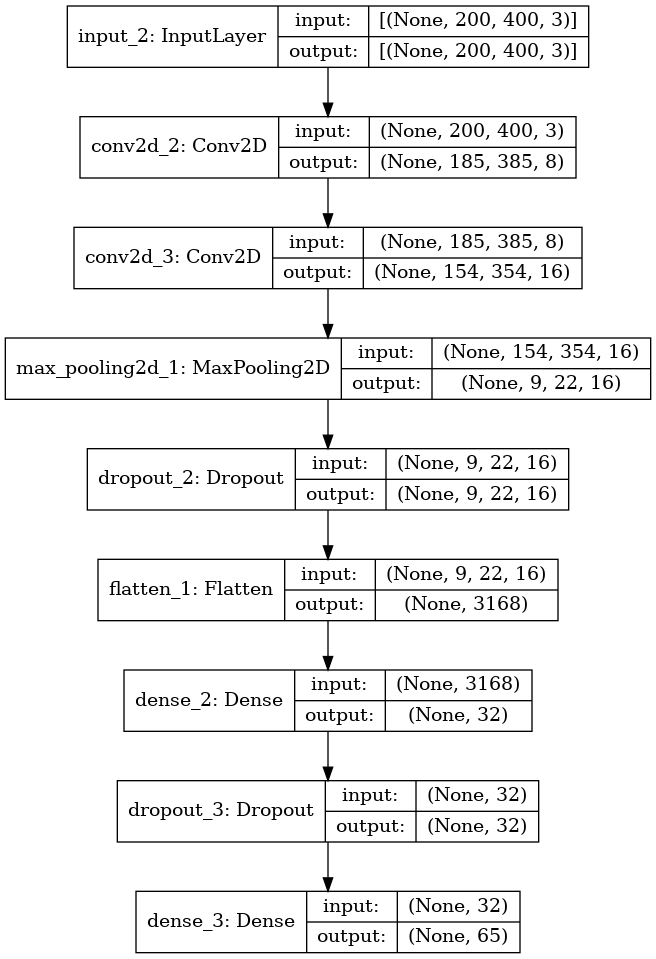

In [64]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)